# Business Problem: Predicting Fraudulent Payment Transactions

Fitris Law has an online retail client who is losing over 10% of annual revenue to fraudulent payments via its online payment portal, which is significantly higher than the industry average (5%).

They have asked my firm to develop a model that will identify potentially fraudulent payments and rank these transactions at the end of each weekly period. 

Using historical payment data extracted from their payment system, I can develop a classification prediction model to identify potential fraudulent transactions (i.e. payments) made by customers.

Although this model is built on payment data for a specified location and contains fields that may not readily be available in other transactional datasets, a similar model can be built for various types of electronic/ACH, credit card, online, P2P transactions, etc.

The source transactional data was extracted from Kaggle contributor: https://www.kaggle.com/turkayavci


In [53]:
#import the necessary libraries

import numpy as np
import pandas as pd
import xlrd
import os
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
ExtraTreesClassifier, VotingClassifier, StackingRegressor, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.over_sampling import SMOTENC
import pickle

import requests
from bs4 import BeautifulSoup
import pandas as pd

from thefuzz import fuzz, process

## 1. EDA: Exploratory Data Analysis

The first step in the modeling process is to perform exploratory data analysis. This includes:
   - Understanding the total quantity of transactions available
   - Identifying the variables that are available in the data, and whether they are binary, continuous or categorical
   - Identifying whether any null values or NAs exist within the dataset that need to be removed or replaced
   - Performing inferential analysis on certain variables. In this case, I will analyze the level of fraud by category, gender and age group
   - Analyzing the target variable for potential class imbalance
    

In [54]:
bankdata_df_orig = pd.read_csv("./source data/bs140513_032310_csv.csv")
bankdata_df_orig.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


### Data Dictionary:

_Step:_ This feature represents the day from the start of the data aggregation. It covers a period of 6 months.

_Customer:_ Customer id

_zipCodeOrigin:_ The zip code of origin/source.

_Merchant:_ The merchant id

_zipMerchant:_ The merchant zip code

_Age:_ Categorized age
0: <= 18,
1: 19-25,
2: 26-35,
3: 36-45,
4: 46:55,
5: 56:65,
6: > 65
U: Unknown

_Gender:_ 
E : Enterprise
F: Female
M: Male
U: Unknown

_Category:_ Category of the purchase

_Amount:_ Amount of the purchase

_Fraud:_ Target - fraudulent(1) or not(0)

Due to volume of transactions in the dataset and the limited amount of RAM on my personal device, I had to randomly sample 100,000 payment transactions from the original source data. The original dataset had 7,200 fraudulent transactions whereas the sampled dataset used for my model has 1,198. Both the original and sampled dataset have approximately 1.2% fraudulent tranactions.

In [55]:
bankdata_df = bankdata_df_orig.sample(n=100000, random_state=42)

In [56]:
#The data collection started on a Monday (step = 1). Add in feature to represent the day of each transaction.

def day_func(numday):
    if (numday - 1) == 0 or (numday - 1) % 7 == 0:
        return 'Monday'
    elif (numday - 2) == 0 or (numday - 2) % 7 == 0:
        return 'Tuesday'
    elif (numday - 3) == 0 or (numday - 3) % 7 == 0:
        return 'Wednesday'
    elif (numday - 4) == 0 or (numday - 4) % 7 == 0:
        return 'Thursday'
    elif (numday - 5) == 0 or (numday - 5) % 7 == 0:
        return 'Friday'
    elif (numday - 6) == 0 or (numday - 6) % 7 == 0:
        return 'Saturday'
    elif (numday - 7) == 0 or (numday - 7) % 7 == 0:
        return 'Sunday'

bankdata_df['day']=bankdata_df['step'].apply(lambda x: day_func(x))

In [57]:
bankdata_df_orig[bankdata_df_orig['fraud'] == 1].count()

step           7200
customer       7200
age            7200
gender         7200
zipcodeOri     7200
merchant       7200
zipMerchant    7200
category       7200
amount         7200
fraud          7200
dtype: int64

In [58]:
bankdata_df[bankdata_df['fraud'] == 1].count()

step           1198
customer       1198
age            1198
gender         1198
zipcodeOri     1198
merchant       1198
zipMerchant    1198
category       1198
amount         1198
fraud          1198
day            1198
dtype: int64

In [59]:
bankdata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 70803 to 234341
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         100000 non-null  int64  
 1   customer     100000 non-null  object 
 2   age          100000 non-null  object 
 3   gender       100000 non-null  object 
 4   zipcodeOri   100000 non-null  object 
 5   merchant     100000 non-null  object 
 6   zipMerchant  100000 non-null  object 
 7   category     100000 non-null  object 
 8   amount       100000 non-null  float64
 9   fraud        100000 non-null  int64  
 10  day          100000 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 9.2+ MB


In [60]:
bankdata_df['fraud'].value_counts(normalize=True)

0    0.98802
1    0.01198
Name: fraud, dtype: float64

In [61]:
bankdata_df['fraud'].value_counts()

0    98802
1     1198
Name: fraud, dtype: int64

We can see that only 1.2% of the payments were identified as being fraudulent. This is a clear imbalanced dataset which I will have to address prior to building a predictive model.

In [62]:
bankdata_df.groupby('category')['amount'].sum().sort_values(ascending=False)

category
'es_transportation'        2295218.78
'es_health'                 369949.82
'es_travel'                 249177.60
'es_food'                   165032.61
'es_wellnessandbeauty'      163941.81
'es_sportsandtoys'          146861.53
'es_fashion'                 69185.68
'es_hotelservices'           60030.01
'es_home'                    57511.34
'es_tech'                    49596.81
'es_hyper'                   48566.30
'es_barsandrestaurants'      43598.62
'es_leisure'                 22388.79
'es_otherservices'           21319.17
'es_contents'                 6437.92
Name: amount, dtype: float64

In [63]:
bankdata_df[bankdata_df['fraud']== 1].groupby('category')['amount','fraud'].sum().sort_values(by='amount',ascending=False)

<ipython-input-63-f824a1c2cb23>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bankdata_df[bankdata_df['fraud']== 1].groupby('category')['amount','fraud'].sum().sort_values(by='amount',ascending=False)


,amount,fraud
category,,
'es_travel',232958.77,90
'es_health',126534.35,298
'es_sportsandtoys',117447.41,336
'es_hotelservices',40521.05,95
'es_home',24552.93,53
'es_wellnessandbeauty',23037.69,101
'es_leisure',22059.54,77
'es_otherservices',12370.10,38
'es_tech',12131.77,28


In [64]:
Avg_fraud_df = bankdata_df[bankdata_df['fraud']== 1].groupby('category')['amount'].mean().sort_values(ascending=False)
Avg_fraud_df

category
'es_travel'                2588.430778
'es_home'                   463.262830
'es_tech'                   433.277500
'es_hotelservices'          426.537368
'es_health'                 424.611913
'es_sportsandtoys'          349.545863
'es_otherservices'          325.528947
'es_leisure'                286.487532
'es_wellnessandbeauty'      228.095941
'es_fashion'                222.866667
'es_hyper'                  195.051064
'es_barsandrestaurants'     154.902353
Name: amount, dtype: float64

In [65]:
bankdata_df[bankdata_df['fraud']== 0].groupby('category')['amount'].mean().sort_values(ascending=False)

category
'es_travel'                648.753200
'es_home'                  114.438924
'es_health'                102.837123
'es_hotelservices'         102.141152
'es_tech'                  102.084578
'es_sportsandtoys'          90.227362
'es_otherservices'          76.487778
'es_leisure'                65.850000
'es_fashion'                60.123690
'es_wellnessandbeauty'      57.582395
'es_contents'               47.688296
'es_barsandrestaurants'     41.337316
'es_hyper'                  38.588541
'es_food'                   36.649480
'es_transportation'         27.023239
Name: amount, dtype: float64

In [66]:
df_fraud = bankdata_df.loc[bankdata_df.fraud == 1] 
df_non_fraud = bankdata_df.loc[bankdata_df.fraud == 0]

In [67]:
graph_df = pd.concat([df_fraud.groupby('category')['amount'].mean(),df_fraud.groupby('category')['amount'].sum(),df_non_fraud.groupby('category')['amount'].mean(),df_non_fraud.groupby('category')['amount'].sum()],keys=["Fraudulent (avg)","Fraudulent (sum)","Not Fraudulent (avg)","Not Fraudulent (sum)"],axis=1)

In [68]:
graph_df = graph_df.reset_index()

In [69]:
graph_df = graph_df.rename(columns={"index":"Category"})
graph_df = graph_df.sort_values(by='Fraudulent (avg)', ascending=False)
graph_df

,Category,Fraudulent (avg),Fraudulent (sum),Not Fraudulent (avg),Not Fraudulent (sum)
10,'es_travel',2588.430778,232958.77,648.753200,16218.83
3,'es_home',463.262830,24552.93,114.438924,32958.41
9,'es_tech',433.277500,12131.77,102.084578,37465.04
4,'es_hotelservices',426.537368,40521.05,102.141152,19508.96
2,'es_health',424.611913,126534.35,102.837123,243415.47
8,'es_sportsandtoys',349.545863,117447.41,90.227362,29414.12
7,'es_otherservices',325.528947,12370.10,76.487778,8949.07
6,'es_leisure',286.487532,22059.54,65.850000,329.25
11,'es_wellnessandbeauty',228.095941,23037.69,57.582395,140904.12
1,'es_fashion',222.866667,4011.60,60.123690,65174.08


In [70]:
bankdata_df[bankdata_df['fraud']== 1]['amount'].sum()

627425.95

Looking at the tables above, we can make the following observations on the dataset:
- Total fraud across the 100,000 transactions was $627,425.95
- The most common (i.e. count) of fraud occurred in the 'sports and toys' category
- The most costly (i.e. total dollars ) of fraud occurred in the 'travel' category
- The average fraudulent transaction is higher than the average non-fraudulent transaction in every category
- There was no fraud identified in the transportation, food, and contents categories.


In [71]:
bankdata_df.isna().sum()

step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
day            0
dtype: int64

The dataset does not have any null or any NA values, so no replacement or removal is necessary.

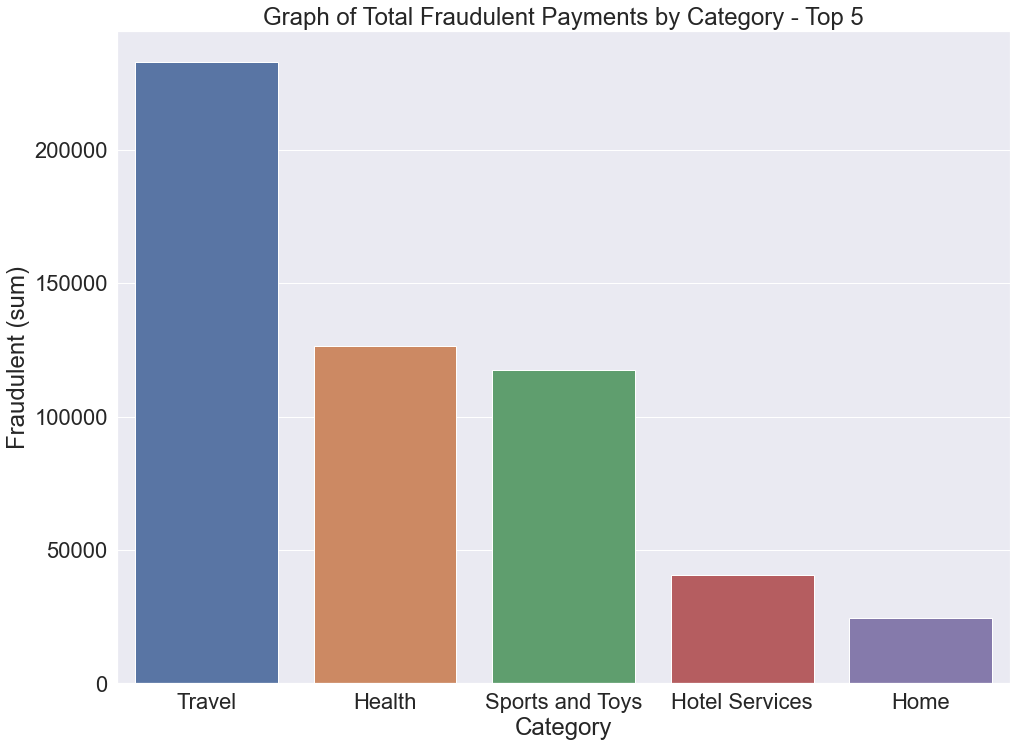

In [80]:
plt.figure(figsize=(16,12))
ax = sns.barplot(y='Fraudulent (sum)' , x='Category', data=graph_df.sort_values('Fraudulent (sum)',ascending=False).head(5))
plt.title("Graph of Total Fraudulent Payments by Category - Top 5")
sns.set(font_scale=3)
ax.set_xticklabels(['Travel','Health','Sports and Toys','Hotel Services','Home'])
plt.savefig('./graphs/Total_fraud_category.png')

plt.show()

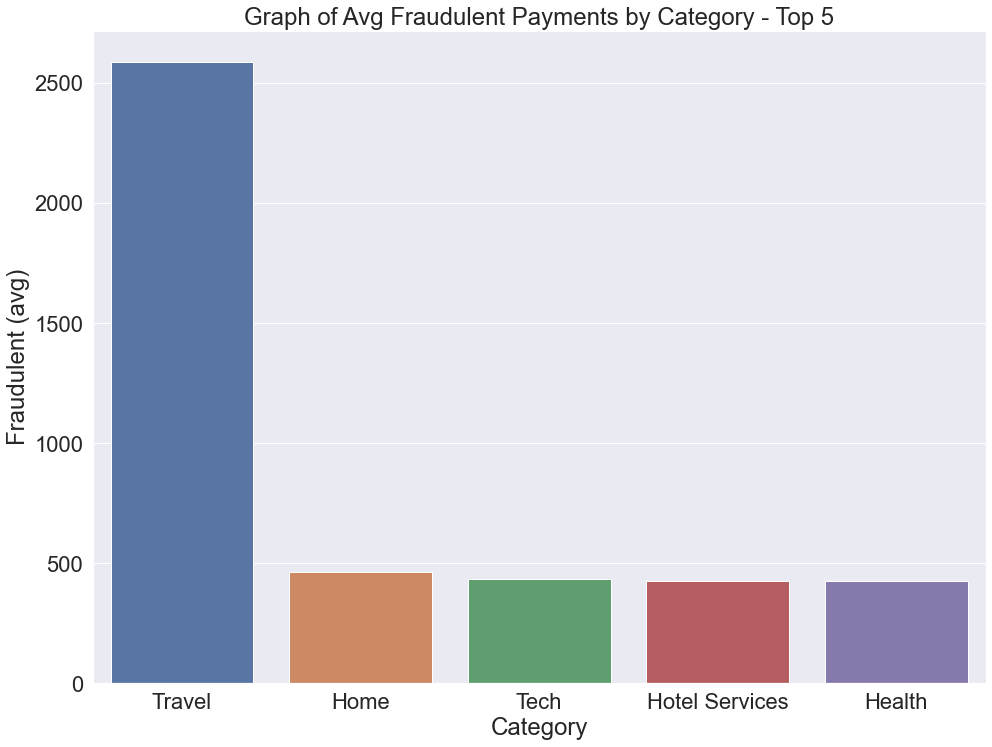

In [26]:
plt.figure(figsize=(16,12))
ax = sns.barplot(y='Fraudulent (avg)' , x='Category', data=graph_df.sort_values('Fraudulent (avg)',ascending=False).head(5))
plt.title("Graph of Avg Fraudulent Payments by Category - Top 5")
ax.set_xticklabels(['Travel','Home','Tech','Hotel Services','Health'])
plt.savefig('./graphs/Avg_fraud_category.png')

plt.show()

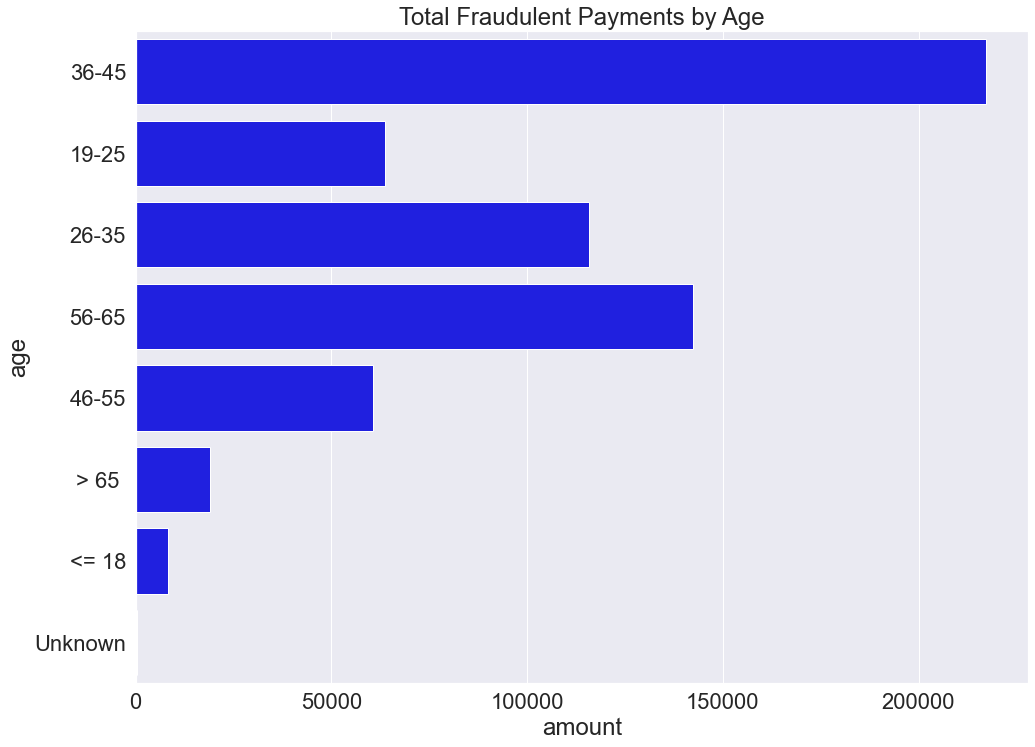

In [27]:
plt.figure(figsize=(16,12))
ax = sns.barplot(y='age', x='amount', color='blue',data=bankdata_df[bankdata_df['fraud']==1],ci=False, estimator=sum)
plt.title("Total Fraudulent Payments by Age")
ax.set_yticklabels(['36-45','19-25','26-35','56-65','46-55','> 65 ','<= 18','Unknown'])
plt.savefig('./graphs/Total_Fraud_ByAge.png')


plt.show()

#0: <= 18, 1: 19-25, 2: 26-35, 3: 36-45, 4: 46:55, 5: 56:65, 6: > 65 U: Unknown

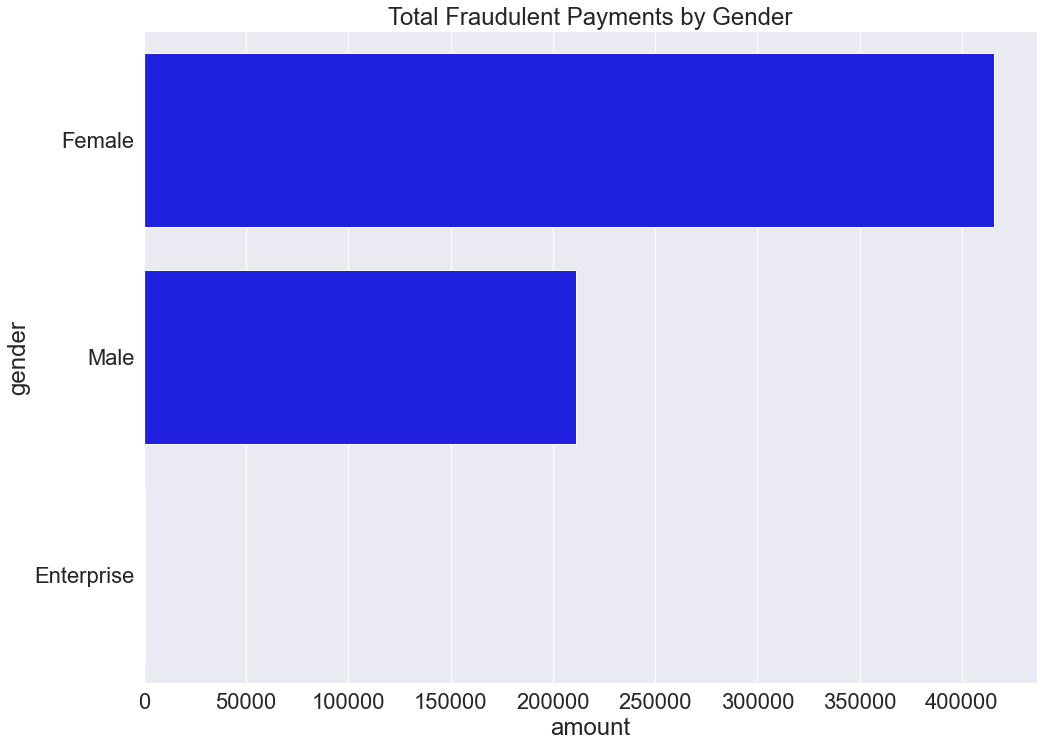

In [82]:
plt.figure(figsize=(16,12))
sns.set(font_scale=2)
ax = sns.barplot(y='gender', x='amount', color='blue',data=bankdata_df[bankdata_df['fraud']==1],ci=False, estimator=sum)
plt.title("Total Fraudulent Payments by Gender")
ax.set_yticklabels(['Female','Male','Enterprise'])
plt.savefig('./graphs/Total_Fraud_ByGender.png')


plt.show()



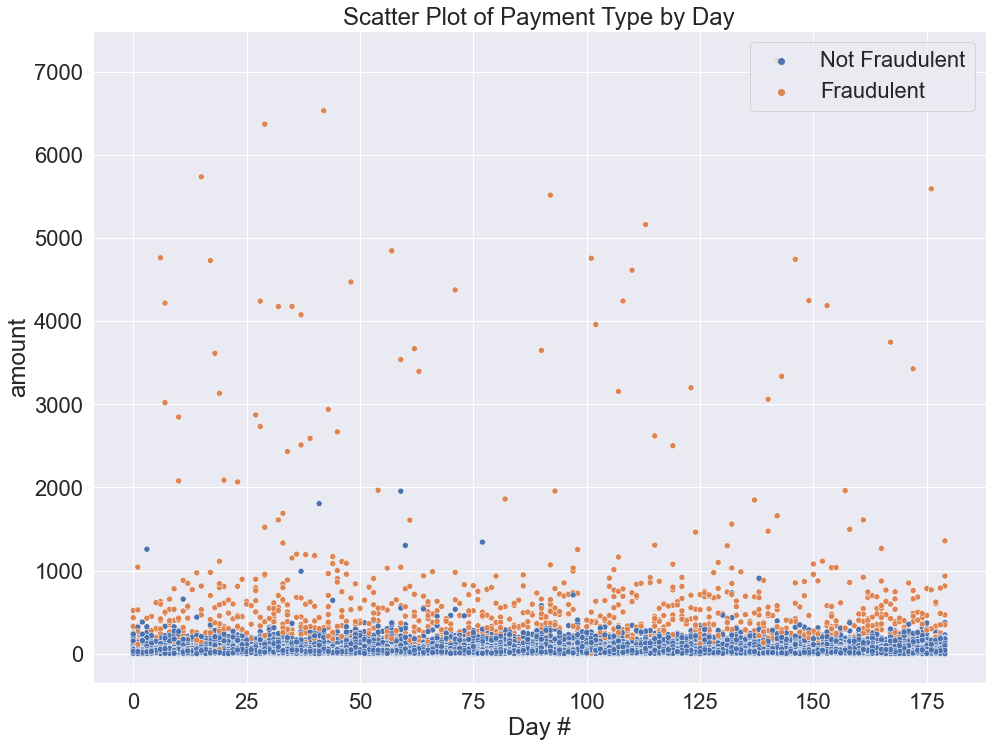

In [83]:
plt.figure(figsize=(16,12))
sns.set(font_scale=2)
ax = sns.scatterplot(x=bankdata_df.step,y=bankdata_df.amount,hue=bankdata_df.fraud)

plt.title("Scatter Plot of Payment Type by Day")

ax.set_xlabel('Day #')

handles, labels  =  ax.get_legend_handles_labels()

ax.legend(handles, ['Not Fraudulent', 'Fraudulent'], loc='upper right')

plt.savefig('./graphs/Total_FraudbyDay.png')

plt.show()

In [23]:
bankdata_df.describe()

,step,amount,fraud
count,100000.00000,100000.000000,100000.000000
mean,94.97734,37.688168,0.011980
std,51.07953,106.917213,0.108796
min,0.00000,0.000000,0.000000
25%,52.00000,13.810000,0.000000
50%,97.00000,27.000000,0.000000
75%,139.00000,42.480000,0.000000
max,179.00000,7134.390000,1.000000


In [31]:
bankdata_df['zipcodeOri'].value_counts()

'28007'    100000
Name: zipcodeOri, dtype: int64

In [32]:
bankdata_df['zipMerchant'].value_counts()

'28007'    100000
Name: zipMerchant, dtype: int64

Since there is only one zipcode and 1 merchant zipcode, I will remove these from the dataframe.

In [24]:
bankdata_df = bankdata_df.drop(columns=['zipcodeOri','zipMerchant','step'])

In [25]:
bankdata_df

,customer,age,gender,merchant,category,amount,fraud,day
70803,'C746862122','3','M','M348934600','es_transportation',11.65,0,Friday
470791,'C1760492708','1','F','M1823072687','es_transportation',1.60,0,Saturday
568310,'C1984083185','3','F','M1823072687','es_transportation',33.36,0,Thursday
23709,'C1530262146','2','M','M1823072687','es_transportation',8.01,0,Tuesday
49723,'C1471216995','3','F','M348934600','es_transportation',38.11,0,Friday
...,...,...,...,...,...,...,...,...
178160,'C382789952','3','M','M348934600','es_transportation',41.98,0,Saturday
134558,'C848738212','4','M','M348934600','es_transportation',45.17,0,Saturday
159282,'C446179646','5','F','M348934600','es_transportation',3.17,0,Sunday
3038,'C1298891864','2','F','M348934600','es_transportation',24.30,0,Monday


In [26]:
bankdata_df['customer'].value_counts()

'C345742557'     51
'C795132749'     51
'C1275518867'    49
'C1978250683'    48
'C1514973352'    47
                 ..
'C1548873226'     1
'C989137613'      1
'C502238060'      1
'C903333805'      1
'C1562081159'     1
Name: customer, Length: 4098, dtype: int64

## 2. Preprocessing the Data

Next, I must preprocess the data to get it ready for the various modeling algorithms applicable for this type of classification problem. Preprocessing steps include:
   - Creating the train and test datasets
   - Applying SMOTE_NC to help alleviate the target class imbalance. SMOTE_NC can specifically be used on datasets that contain both continuous and categorical variables.
   - Creating a pipeline that will apply standard scaler to continuous variables and one hot encode categorical variables, and then use column transformer
   

In [34]:
bankdata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 70803 to 234341
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   customer  100000 non-null  object 
 1   age       100000 non-null  object 
 2   gender    100000 non-null  object 
 3   merchant  100000 non-null  object 
 4   category  100000 non-null  object 
 5   amount    100000 non-null  float64
 6   fraud     100000 non-null  int64  
 7   day       100000 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 6.9+ MB


In [35]:
subpipe_num = Pipeline(steps=[
    ('ss', StandardScaler())
])


subpipe_cat = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

CT = ColumnTransformer(transformers = [
    ('subpipe_num', subpipe_num, selector(dtype_include = np.number)),
    ('subpipe_cat', subpipe_cat, selector(dtype_include = object))
], remainder = 'passthrough')

In [36]:
X = bankdata_df.drop(['fraud'],axis=1)
y = bankdata_df['fraud']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [38]:
y_train.value_counts()

0    74126
1      874
Name: fraud, dtype: int64

Due to there being so few examples of fraud in the dataset (only 1.2%), I have applied SMOTENC below to increase the minority class of the train dataset to be at least 25% of the train majority class (i.e. not fraud).

In [40]:
smote_nc = SMOTENC(categorical_features=[0,1,2,3,4,6],sampling_strategy=.5,random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)


In [41]:
y_resampled.value_counts()

0    74126
1    37063
Name: fraud, dtype: int64

In [42]:
y_resampled.value_counts(normalize = True)

0    0.666667
1    0.333333
Name: fraud, dtype: float64

Now the class is slightly more balanced, with 37,063 examples of the "fraud" target (or 33% of the sampled population).

## 3. Modeling, Cross Validation and GridSearching

I use the cross validation class taken from FlatIron lecture 51, and then apply certain types of classification models including:
   - Dummy classifier
   - Logistic Regression
   - KNN
   - Random Forest
   - GradientBoost Classifier

In [43]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)
    
    def cvmean(self):
        cvmean2 = round(self.cv_mean,3)
        print(cvmean2)

In [45]:
dummy_model_pipe = Pipeline(steps= [
    ('ct', CT),
    ('dum', DummyClassifier(strategy = 'most_frequent'))
])

dummy_pipe = ModelWithCV(dummy_model_pipe, 'dummy model', X_resampled, y_resampled)
dummy_pipe.print_cv_summary()

CV Results for `dummy model` model:
            0.66667 ± 0.00004 accuracy
        


In [44]:
logreg_model_pipe = Pipeline([
    ('ct', CT),
    ('logreg', LogisticRegression(random_state=42, max_iter=5000))
])

#I set max_iter to 5,000, as i received errors when I left max_iter at the default value of 100.
#5,000 seems to work well and provide a good average accuracy score.

logreg_pipe = ModelWithCV(logreg_model_pipe,'logreg_model', X_resampled, y_resampled)
logreg_pipe.print_cv_summary()

CV Results for `logreg_model` model:
            0.99560 ± 0.00092 accuracy
        


In [ ]:
knn_model_pipe = Pipeline([
    ('ct',CT),
    ('knn',KNeighborsClassifier())
])

knn_pipe = ModelWithCV(knn_model_pipe,'knn_model', X_resampled, y_resampled)
knn_pipe.print_cv_summary()

In [ ]:
rfc_model_pipe = Pipeline([
    ('ct',CT),
    ('rfc',RandomForestClassifier(random_state = 42,max_depth=9))
])

rfc_pipe = ModelWithCV(rfc_model_pipe,'rfc_model', X_resampled, y_resampled)
rfc_pipe.print_cv_summary()

In [ ]:
gbc_model_pipe = Pipeline([
    ('ct',CT),
    ('gbc',GradientBoostingClassifier(random_state = 42))
])

gbc_pipe = ModelWithCV(gbc_model_pipe,'gbc_model', X_resampled, y_resampled)
gbc_pipe.print_cv_summary()

In [ ]:
CV_Mean_Score = [dummy_pipe.cv_mean, logreg_pipe.cv_mean,
rfc_pipe.cv_mean,
gbc_pipe.cv_mean,
knn_pipe.cv_mean]

CV_STD = [dummy_pipe.cv_std, logreg_pipe.cv_std,
rfc_pipe.cv_std,
gbc_pipe.cv_std,
knn_pipe.cv_std]

Model_Type = ['Dummy Classifier', 'Logistic Regression','Random Forest Classifier','Gradient Boosting Classifier',
'KNN']

data = {'Model Type':Model_Type, 'CV Mean Score':CV_Mean_Score, 'CV STD':CV_STD}
df_score = pd.DataFrame(data)

df_score.sort_values(by='CV Mean Score', ascending=False).reset_index(drop=True)

### Apply Gridsearch to LogReg, RFC and KNN, which had very high accuracy scores

I applied GridSearch to the logreg pipeline, as it had the highest average accuracy score when compared to the other classification models. Initially, I tried to gridsearch on all 4 'penalty' hyperparameter options, along with certain 'solver' hyperparameter options, but certain of these parameters cannot be used together and the GridSearch wouldfail. Therefore, I simply applied the 'l2' and 'none' hyperparameter options to identify the better model.

In [ ]:
#Tuning and Cross Validating of RFC. Here we add in some of the important selection criteria for RFC.
logreg_params = {}
logreg_params['logreg__penalty']=['l2','none']
#logreg_params['logreg__solver']= ['lbfgs', 'sag', 'saga']
#'elasticnet', 'l1',

gs_logreg = GridSearchCV(logreg_model_pipe, logreg_params, cv=5, verbose=1)
gs_logreg.fit(X_resampled, y_resampled)
gs_logreg.best_params_

In [ ]:
gs_logreg.best_score_

In [45]:
Final_logreg_model_pipe = Pipeline([
    ('ct', CT),
    ('logreg', LogisticRegression(random_state=42, max_iter=5000, penalty='none'))
])

Final_logreg_model_pipe.fit(X_resampled, y_resampled)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001E22568DF70>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001E22568DFA0>)])),
                ('logreg',
                 LogisticRegression(m

In [48]:
pickle.dump(Final_logreg_model_pipe,open("./pickled models/final_logreg_fraud_model.sav",'wb'))

In [47]:
Final_logreg_model_pipe.score(X_test, y_test)

0.99344

I also ran gridsearches on the RFC and KNN pipelines, but have inserted markdowns below as it would take a couple of hours to run each. Logistic Regression pipeline still resulted with the highest test score.

In [ ]:
rfc_params = {}
rfc_params['rfc__criterion'] = ['gini','entropy']
rfc_params['rfc__min_samples_leaf'] = [5,10,15]
rfc_params['rfc__max_depth'] = [5,7,9]

gs_rfc = GridSearchCV(rfc_model_pipe, rfc_params, cv=5, verbose=1)
gs_rfc.fit(X_resampled, y_resampled)
gs_rfc.best_params_

In [ ]:
gs_rfc.best_score_

In [ ]:
# knn_params = {}
# knn_params['knn__n_neighbors']=[300,500,700]
# knn_params['knn__weights']=['uniform','distance']
# knn_params['knn__algorithm']='auto',
# knn_params['knn__leaf_size']=[5000,10000]
# knn_params['knn__p']=[1,2]

# gs_knn = GridSearchCV(knn_model_pipe, knn_params, cv=5, verbose=1)
# gs_knn.fit(X_resampled, y_resampled)
# gs_knn.best_params_

In [ ]:
# gs_knn.best_score_

## 4. Final Classification Model - Confusion Matrix

In [ ]:
y_hat = Final_logreg_model_pipe.predict(X_test)

In [ ]:
print(classification_report(y_test,y_hat))

In [ ]:
#Plot a confusion matric on actual and preditions of the test data.
ax = plt.subplot()
sns.set(font_scale=1) # Adjust to fit

plot_confusion_matrix(Final_logreg_model_pipe, X_test, y_test, ax=ax,  cmap = plt.cm.Greys, display_labels=['Not Fraud','Fraud'])

# Labels, title and ticks
label_font = {'size':'16'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);
ax.grid(b=False);

title_font = {'size':'16'}  # Adjust to fit
ax.set_title('Confusion Matrix', fontdict=title_font);

plt.savefig('./graphs/Confusion Matrix')

plt.show()

## 5. Applying Final Model to Additional Unseen and Untested Fraudulent Payment Data

In [ ]:
sample_df = pd.read_csv("./source data/sample_transactions2.csv")
sample_df_2 = sample_df[['step','customer','age','gender','merchant','category','amount']]

loaded_model = pickle.load(open("./pickled models/final_logreg_fraud_model.sav", 'rb'))

preds = loaded_model.predict(sample_df_2)
preds_proba = loaded_model.predict_proba(sample_df_2)
df_prediction = pd.DataFrame(zip(preds,preds_proba[:,1]*100),columns=['Fraud Prediction','Probability(%)'])
df_prediction['Potentially Fraudulent?'] = np.where(df_prediction['Fraud Prediction'] == 1, 'Yes', 'No')
df_combined = sample_df.join(df_prediction)


In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_combined.sort_values(by='Fraud Prediction', ascending = True).head(40)

In [ ]:
count_fraud_prediction = len(df_combined[df_combined['Fraud Prediction'] == 1])
print (f'Out of 100 fraudulent transactions in the sample_transactions2.csv file, my final model correctly identified {count_fraud_prediction} transactions as being fraudulent')

In [12]:
bankdata_df

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud,day
70803,26,'C746862122','3','M','28007','M348934600','28007','es_transportation',11.65,0,Friday
470791,146,'C1760492708','1','F','28007','M1823072687','28007','es_transportation',1.60,0,Saturday
568310,172,'C1984083185','3','F','28007','M1823072687','28007','es_transportation',33.36,0,Thursday
23709,9,'C1530262146','2','M','28007','M1823072687','28007','es_transportation',8.01,0,Tuesday
49723,19,'C1471216995','3','F','28007','M348934600','28007','es_transportation',38.11,0,Friday
...,...,...,...,...,...,...,...,...,...,...,...
178160,62,'C382789952','3','M','28007','M348934600','28007','es_transportation',41.98,0,Saturday
134558,48,'C848738212','4','M','28007','M348934600','28007','es_transportation',45.17,0,Saturday
159282,56,'C446179646','5','F','28007','M348934600','28007','es_transportation',3.17,0,Sunday
3038,1,'C1298891864','2','F','28007','M348934600','28007','es_transportation',24.30,0,Monday


## 6. Recommendations / Online Application

1. At the end of each weekly or two-week period, feed the Final Logistic Regression model with payment detail

2. Continuously update the model to include additional locations (i.e. zipcode)

3. Investigate the identified transactions and prevent delivery of any product or service unless payment has been verified


You can upload any payment data with the required fields and the model will identify which transactions are potentially fraudulent:
    
https://alirampur-flatiron-capstone-streamlit-capstone-yx8toc.streamlitapp.com/
